In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [22]:
from mpi4py import MPI
from dolfinx import mesh

N = 21
domain = mesh.create_unit_interval(MPI.COMM_SELF, N)
print(domain)

In [23]:
from dolfinx.fem import FunctionSpace

V = FunctionSpace(domain, ("CG", 1))
print(V)

FunctionSpace(Mesh(VectorElement(Basix element (P, interval, 1, gll_warped, unset, False), 1), 137), Basix element (P, interval, 1, gll_warped, unset, False))


In [24]:
from dolfinx import fem
from petsc4py.PETSc import ScalarType

domain.topology.create_connectivity(0, 1)


facets = mesh.locate_entities_boundary(domain, dim=0,
                                       marker=lambda x: np.logical_or(np.isclose(x[0], 0.0),
                                                                      np.isclose(x[0], 1.0)))
bc_dofs = fem.locate_dofs_topological(V=V, entity_dim=0, entities=facets)

bc = fem.dirichletbc(ScalarType(0), bc_dofs, V)

print(bc_dofs)
print(bc)



[ 0 21]


In [25]:
import ufl

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(domain)


# f = sin(w * pi * x), w = 1, 10
w = fem.Constant(domain, ScalarType(1))
pi = fem.Constant(domain, ScalarType(np.pi))
f = ufl.sin(w * pi * x[0])

u_ex_f = lambda x: np.sin(w.value * np.pi * x) / (w.value**2 * np.pi**2)

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx


In [26]:
problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()


''

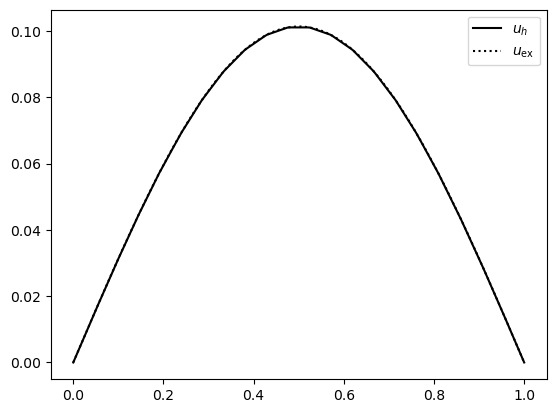

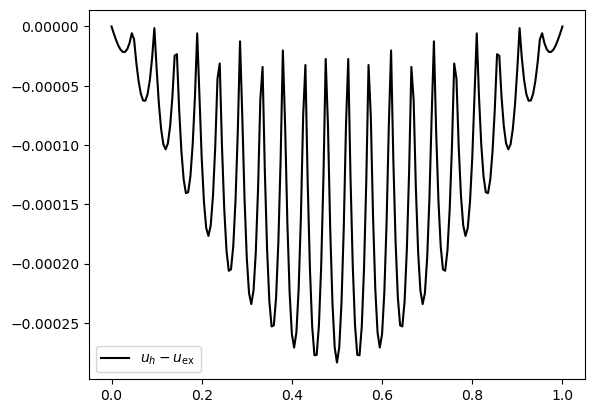

In [27]:
from dolfinx import geometry

bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

N_points = 201
eps=1e-6
points = np.zeros((3, N_points))
points[0,:] = np.linspace(0+eps, 1-eps, N_points)

cells = []

# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    cells.append(colliding_cells.links(i)[0])
    
u_values = uh.eval(points.T, cells)


plt.figure()

plt.plot(points[0,:], u_values[:,0], 'k-', label=r"$u_h$")
plt.plot(points[0,:], u_ex_f(points[0,:]), 'k:', label=r"$u_\mathrm{ex}$")
plt.legend()

plt.figure()

plt.plot(points[0,:], u_values[:,0] - u_ex_f(points[0,:]), 'k-', label=r"$u_h - u_\mathrm{ex}$")
plt.legend()
;


In [17]:

from timeit import default_timer as timer

def error_test(N_x, p):
    
    start = timer()
    
    domain = mesh.create_unit_interval(MPI.COMM_SELF, N_x)
    V = FunctionSpace(domain, ("CG", p))
    
    domain.topology.create_connectivity(0, 1)
    facets = mesh.locate_entities_boundary(domain, dim=0,
                    marker=lambda x: np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)))
    bc_dofs = fem.locate_dofs_topological(V=V, entity_dim=0, entities=facets)
    bc = fem.dirichletbc(ScalarType(0), bc_dofs, V)
    
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    x = ufl.SpatialCoordinate(domain)

    # f = sin(w * pi * x), w = 1, 10
    w = fem.Constant(domain, ScalarType(1))
    pi = fem.Constant(domain, ScalarType(np.pi))
    f = ufl.sin(w * pi * x[0])

    u_ex_f = lambda x: np.sin(w.value * np.pi * x) / (w.value**2 * np.pi**2)

    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)

    a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
    L = f * v * ufl.dx
    
    #print("foo", domain.geometry.x.shape)
    problem = fem.petsc.LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    uh = problem.solve()
    
    end = timer()
    
    bb_tree = geometry.BoundingBoxTree(domain, domain.topology.dim)

    N_points = 2001
    eps=1e-8
    points = np.zeros((3, N_points))
    points[0,:] = np.linspace(0+eps, 1-eps, N_points)

    cells = []

    # Find cells whose bounding-box collide with the the points
    cell_candidates = geometry.compute_collisions(bb_tree, points.T)
    # Choose one of the cells that contains the point
    colliding_cells = geometry.compute_colliding_cells(domain, cell_candidates, points.T)
    for i, point in enumerate(points.T):
        cells.append(colliding_cells.links(i)[0])

    u_values = uh.eval(points.T, cells)[:,0]
    
    e = u_ex_f(points[0,:]) - u_values
    
    L_inf = np.amax(np.abs(e))
    L_2 = np.sqrt( 0.5 * ( points[0,1] - points[0,0] ) * ( np.sum(e[:-1]**2) + np.sum(e[1:]**2) ) )
    
    del domain, V, facets, bc_dofs, bc, u, v, x, a, L, problem, uh, bb_tree, points, cells, cell_candidates, \
        colliding_cells, u_values, e
    
    return end - start, L_2, L_inf

results = []
ps = [1, 2, 3]
N_xs = [2, 4, 8, 16, 32, 64, 128, 256]

results = np.zeros((len(ps), 3, len(N_xs)))

for i, p in enumerate(ps):
    for j, N_x in enumerate(N_xs):
        T, L_2, L_inf = error_test(N_x, p)
        
        results[i, 0, j] = T + 0.0
        results[i, 1, j] = L_2 + 0.0
        results[i, 2, j] = L_inf + 0.0

    

''

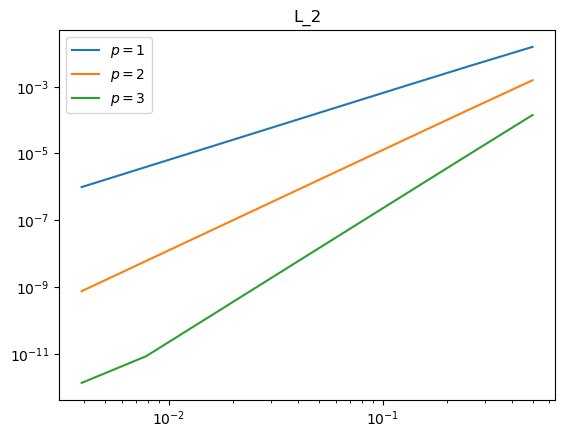

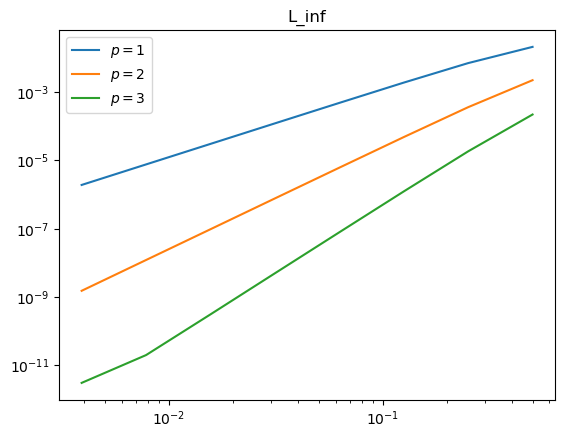

In [18]:

plt.figure()
plt.title("L_2")
plt.loglog(1 / np.array(N_xs), results[0,1,:], label="$p=1$")
plt.loglog(1 / np.array(N_xs), results[1,1,:], label="$p=2$")
plt.loglog(1 / np.array(N_xs), results[2,1,:], label="$p=3$")
plt.legend()

plt.figure()
plt.title("L_inf")
plt.loglog(1 / np.array(N_xs), results[0,2,:], label="$p=1$")
plt.loglog(1 / np.array(N_xs), results[1,2,:], label="$p=2$")
plt.loglog(1 / np.array(N_xs), results[2,2,:], label="$p=3$")
plt.legend()
;


In [37]:
from dolfinx import plot
import pyvista

tdim = domain.topology.dim

topology, cell_types, geometry = plot.create_vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

In [ ]:
pyvista.set_jupyter_backend("pythreejs")


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



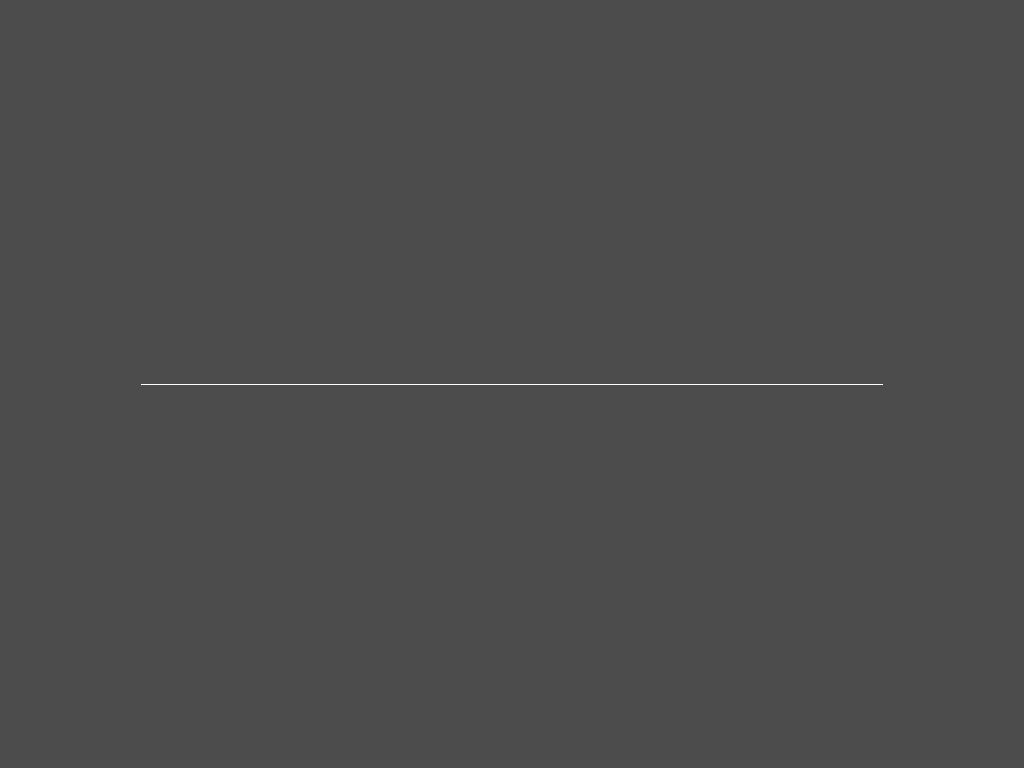

In [38]:
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()

In [40]:
u_topology, u_cell_types, u_geometry = plot.create_vtk_mesh(V)

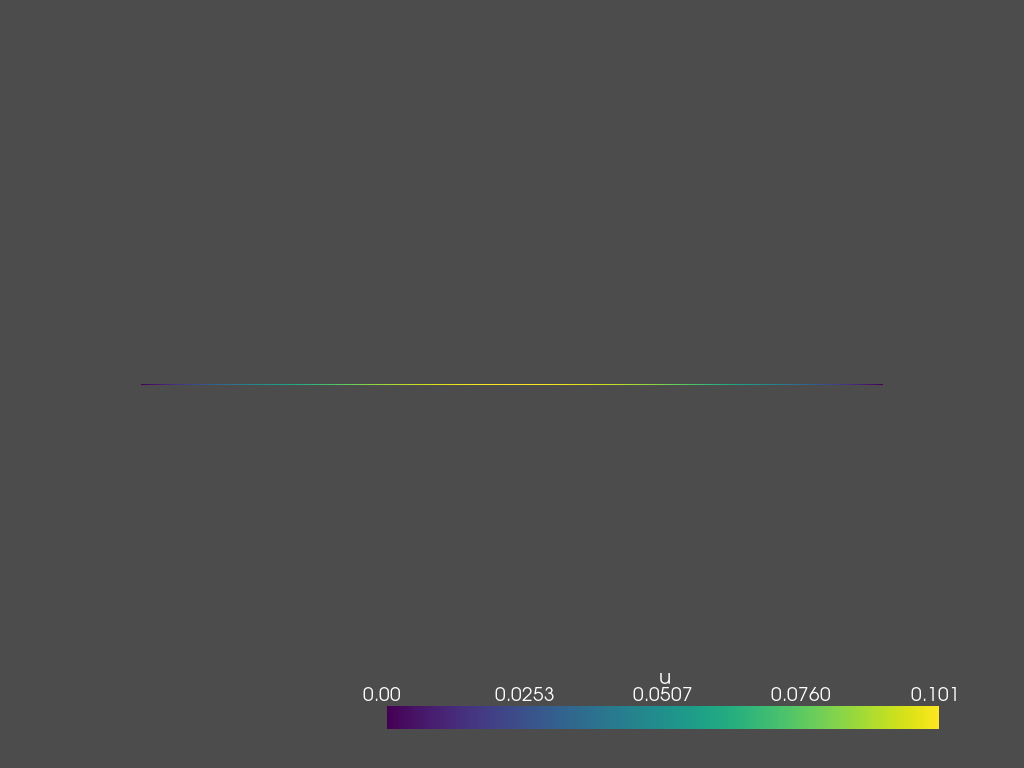

In [43]:
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()